# Ensemble: siconc

## Imports & defaults

In [1]:
import libs.analysis
import libs.plot
import libs.utils
import libs.vars
import matplotlib
import numpy as np
import xarray

matplotlib.rcParams.update({ 'font.size': 18 })

/home/users/woodward/.conda/envs/climate/lib/python3.9/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


## Data

In [2]:
# ----- SPECIFIC SETTINGS -----
component = 'SImon'
experiment = 'ssp585'
variable_id = 'siconc'

spatial_text = 'sea-ice concentration'
spatial_units = '%'

time_series_text = 'sea-ice area'
time_series_weighted_method = 'sum'
time_series_units = 'km²'
time_series_y_label = f'Area ({time_series_units})'
time_series_y_range = (0, 1.2e7)

# Convert from m2 to km2 and % to fraction
time_series_process = lambda x: x / (1000 * 1000 * 100)

colormesh_kwargs = {
    'extend': 'neither',
    'levels': 11,
    #'shading': 'auto', # NB change to 'gouraud' if Jaspy
    'vmin': 0,
    'vmax': 100,
    'x': 'longitude', 
    'y': 'latitude'
}


# ----- GENERIC -----
ensemble = libs.vars.ensemble()

# Since variables have been regridded, can use UKESM areacello
# for all ensemble member weighted means/sums
areacello = libs.utils.get_data('Ofx', 'piControl', 'UKESM1-0-LL', 'areacello', 'r1i1p1f2').areacello
weight = areacello.fillna(0)

# Get nsidc region mask, which has been regridded to UKESM ocean grid
path_nsidc_mask = '_data/_cache/NSIDC_Regions_Masks_Ocean_nearest_s2d.nc'
nsidc_mask = xarray.open_mfdataset(paths=path_nsidc_mask, combine='by_coords').mask
nsidc_all = [
    r for r in libs.vars.nsidc_regions() if r['label'] == 'All'
][0]

# Retrieve all ensemble data
for i, item in enumerate(ensemble):
    source_id = item['source_id']
    variant_label = item['variant_label']
    
    var_base = libs.utils.get_data(component, experiment, source_id, variable_id, variant_label)
    
    # Mask to arctic + nsidc regions
    var_base[variable_id] = var_base[variable_id]\
        .where(var_base[variable_id].latitude > 60)\
        .where(np.isin(nsidc_mask.values, nsidc_all['values']))
    
    ensemble[i]['data'] = var_base[variable_id]
    ensemble[i]['label'] = var_base.attrs['source_id']


ensemble_weighted_reduced = []
ensemble_weighted_reduced_smooth = []
ensemble_weighted_reduced_sep_mar = []

for item in ensemble:
    item_data = time_series_process(item['data'])
    item_data_weighted = item_data.weighted(weight)

    # Reduce data, i.e. taking sum or average over spatial dimensions
    item_data_reduced = getattr(item_data_weighted, time_series_weighted_method)(
        dim=item_data_weighted.weights.dims, 
        skipna=True
    )
    
    item_base_kwargs = {
        'color': item['color'],
        'label': item['label']
    }

    ensemble_weighted_reduced.append(
        { **item_base_kwargs, **{ 'data': item_data_reduced } }
    )
    ensemble_weighted_reduced_smooth.append(
        { **item_base_kwargs, **{ 'data': libs.analysis.smoothed_mean(item_data_reduced) } }
    )
    
    item_reduced_sep = getattr(
        item_data.where(item_data.time['time.month'] == 9, drop=True).weighted(weight), 
        time_series_weighted_method
    )(dim=item_data_weighted.weights.dims, skipna=True)
    
    item_reduced_mar = getattr(
        item_data.where(item_data.time['time.month'] == 3, drop=True).weighted(weight), 
        time_series_weighted_method
    )(dim=item_data_weighted.weights.dims, skipna=True)

    ensemble_weighted_reduced_sep_mar.append({ **item_base_kwargs, **{ 
        'data': item_reduced_sep,
        'plot_kwargs': { 'linestyle': 'dashed' },
    } })
    ensemble_weighted_reduced_sep_mar.append({ **item_base_kwargs, **{ 
        'data': item_reduced_mar
    } })


ensemble_weighted_reduced_smooth.append(
    libs.analysis.ensemble_mean(ensemble_weighted_reduced_smooth)
)

# Generate slices
ensemble_time_slices = libs.analysis.generate_slices(ensemble)

## Time series

### Mean

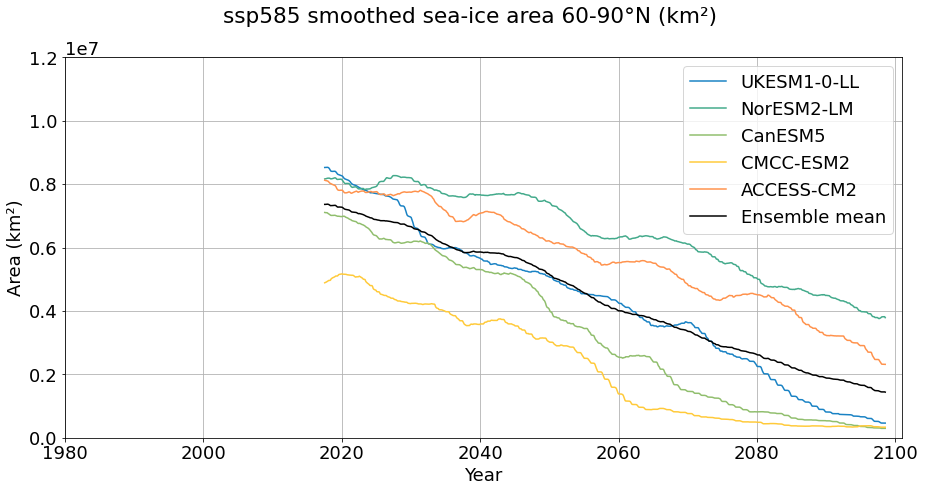

In [3]:
libs.plot.time_series(
    ensemble_weighted_reduced_smooth,
    title=f'{experiment} smoothed {time_series_text} 60-90°N ({time_series_units})',
    xattr='time',
    ylabel=time_series_y_label,
    yrange=time_series_y_range
)

### September (min) & March (max)

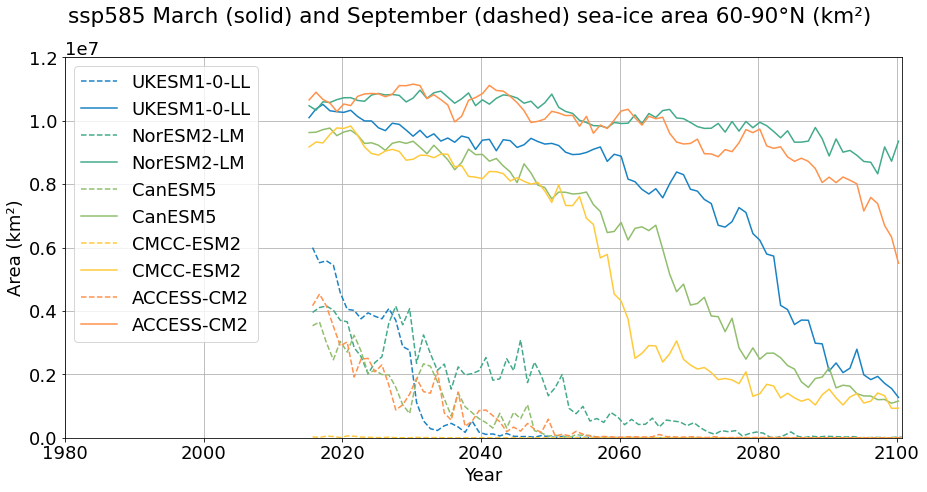

In [4]:
libs.plot.time_series(
    ensemble_weighted_reduced_sep_mar,
    title=f'{experiment} March (solid) and September (dashed) {time_series_text} 60-90°N ({time_series_units})',
    xattr='time',
    ylabel=time_series_y_label,
    yrange=time_series_y_range
)

### Full variability

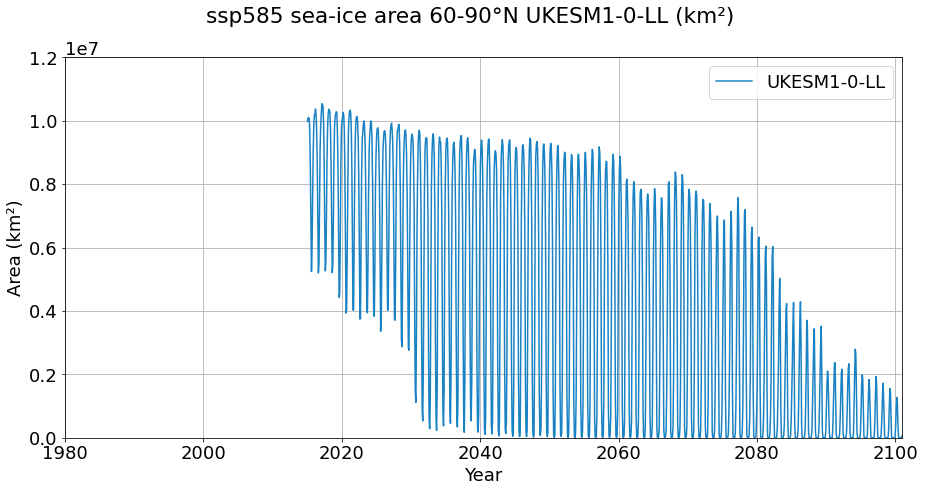

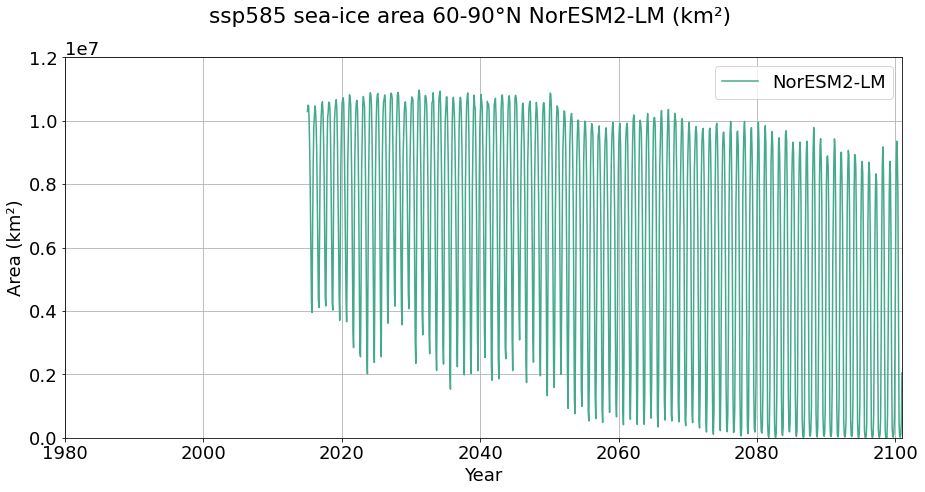

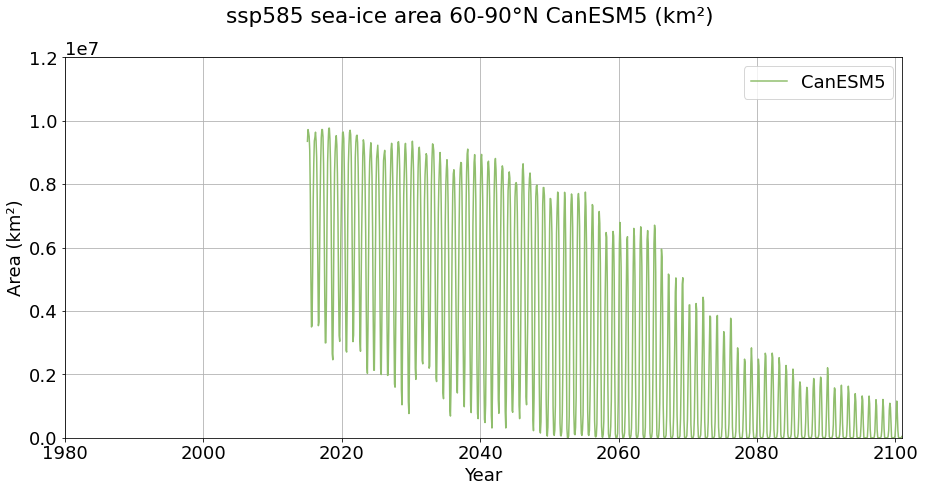

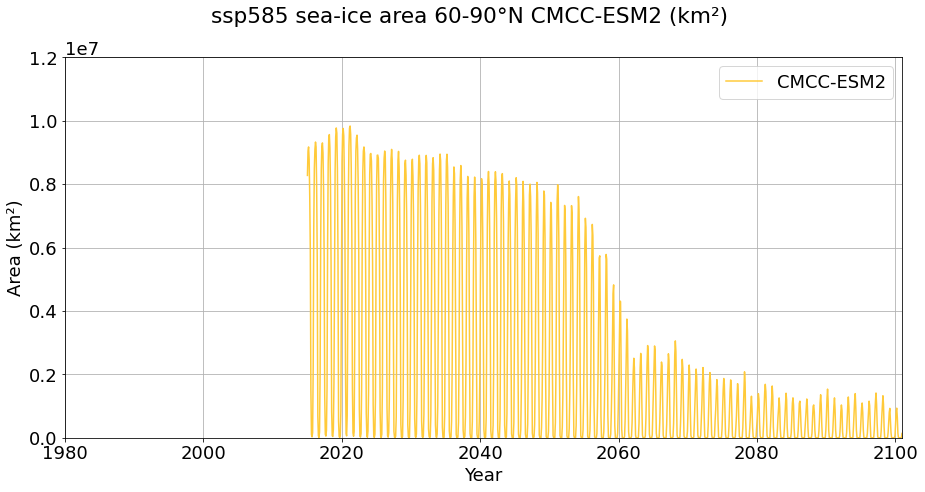

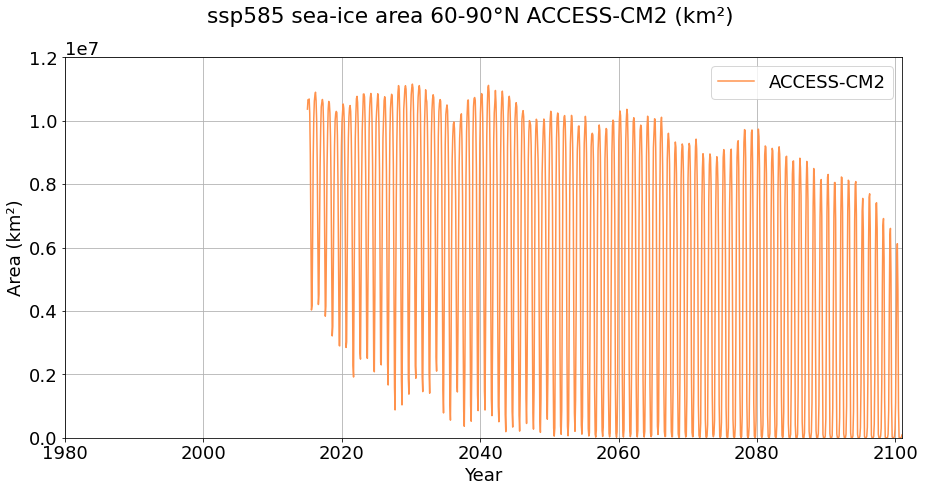

In [5]:
for item in ensemble_weighted_reduced:
    member = item['label']

    libs.plot.time_series(
        [item],
        title=f'{experiment} {time_series_text} 60-90°N {member} ({time_series_units})',
        xattr='time',
        ylabel=time_series_y_label,
        yrange=time_series_y_range
    )

## Monthly variability

### Full region (time)

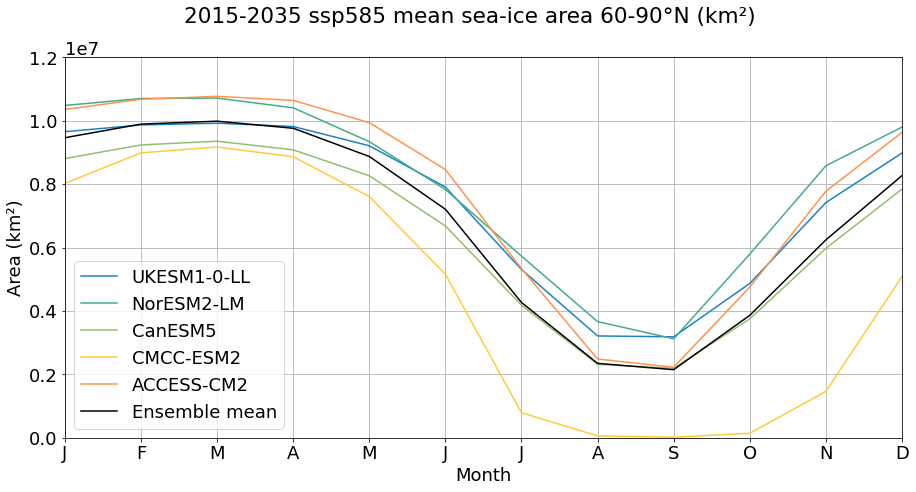

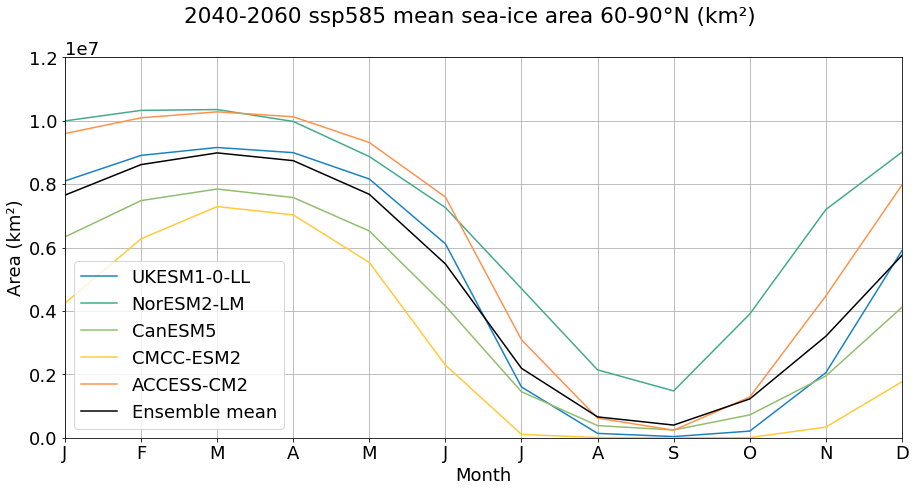

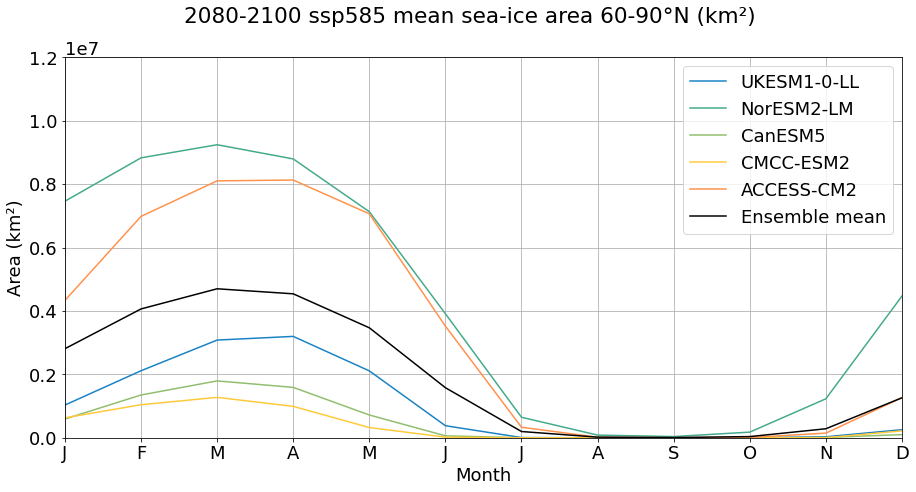

In [6]:
for s in ensemble_time_slices:
    ensemble_processed = [{ 
        'color': item['color'],
        'data': libs.analysis.monthly_weighted(
            time_series_process(item['data']),
            weight,
            method=time_series_weighted_method
        ),
        'label': item['label']
    } for item in s['ensemble']]
    
    # Calculate and add ensemble mean
    ensemble_processed.append(libs.analysis.ensemble_mean(ensemble_processed))
    
    s_label = s['label']
    libs.plot.monthly_variability(
        ensemble_processed,
        title=f'{s_label} {experiment} mean {time_series_text} 60-90°N ({time_series_units})',
        ylabel=time_series_y_label,
        yrange=time_series_y_range
    )

### Regional sea-ice area (time)

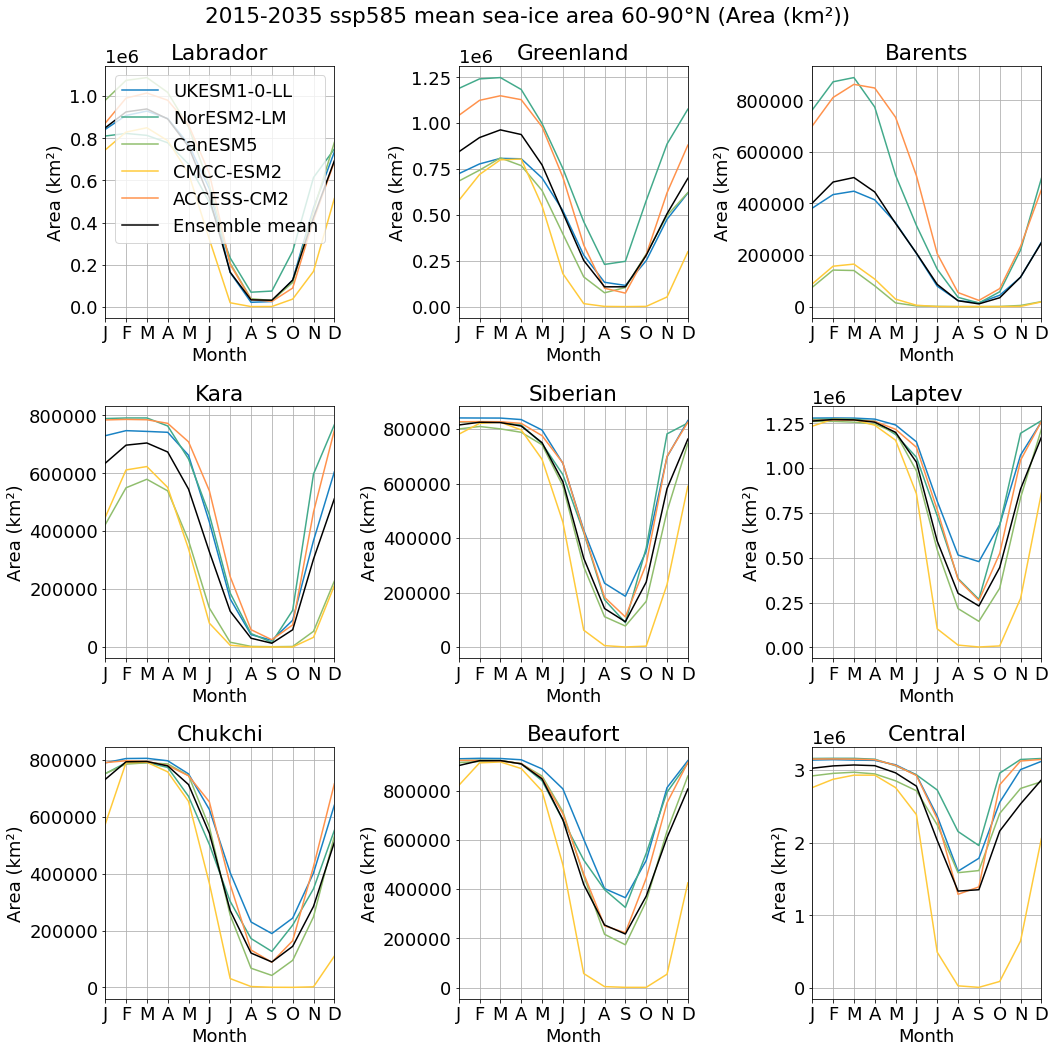

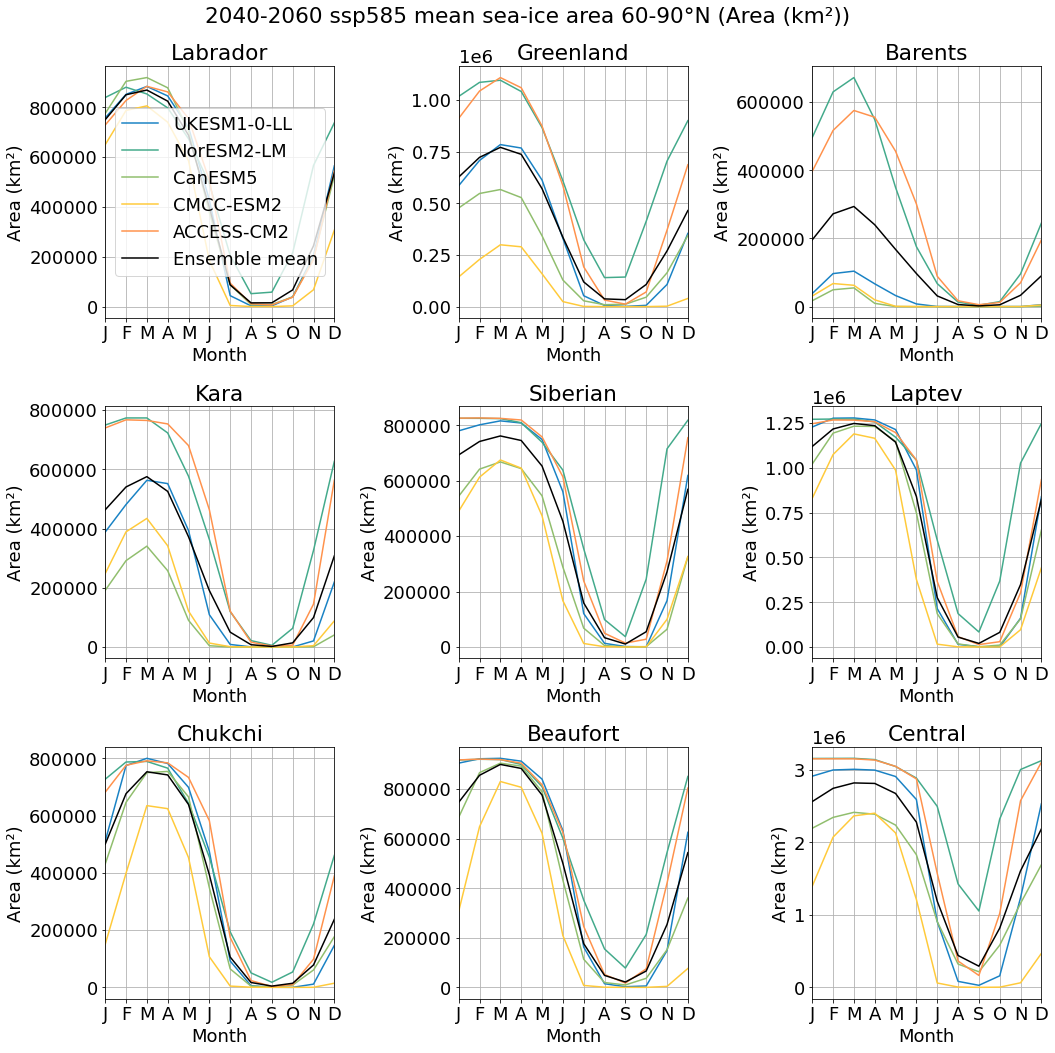

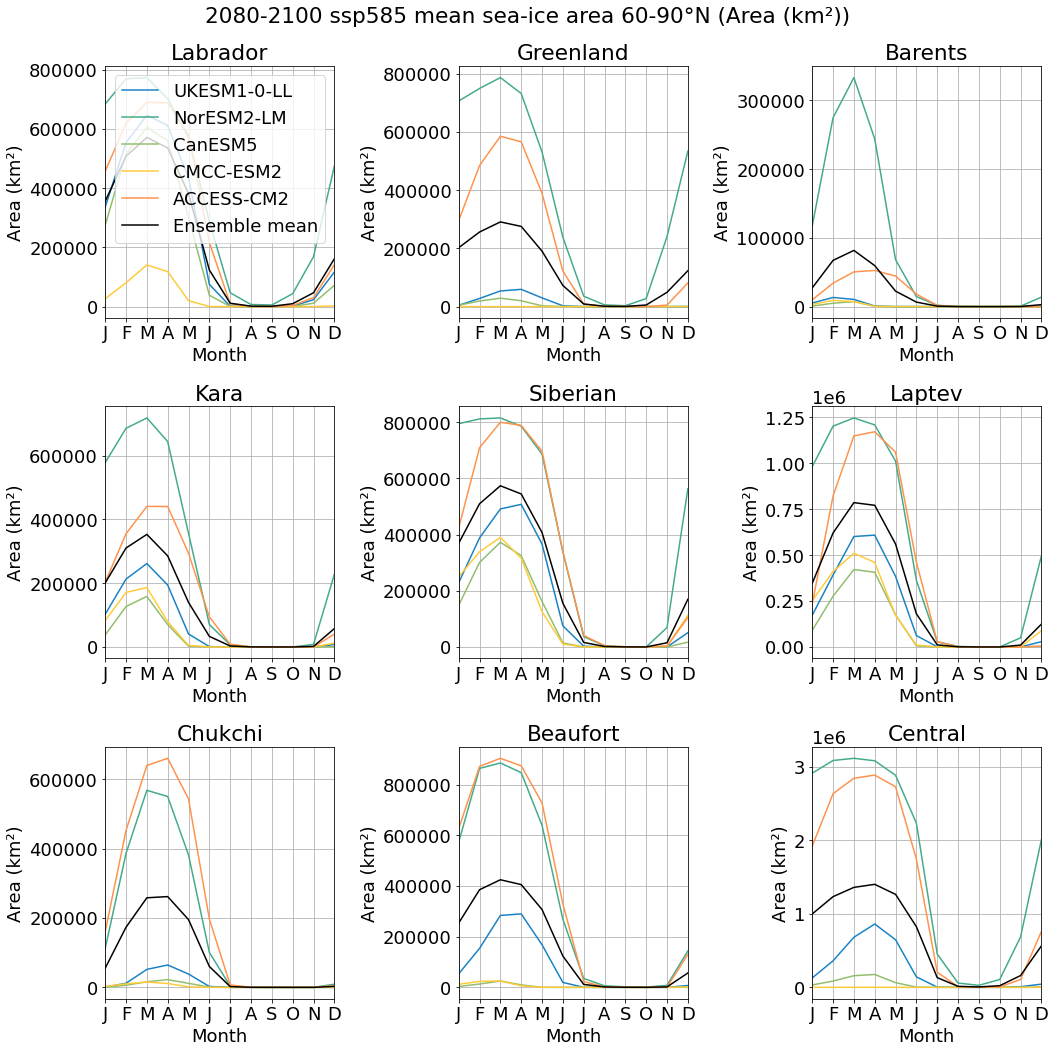

In [7]:
for s in ensemble_time_slices:
    s_label = s['label']

    libs.plot.monthly_variability_regional(
        s['ensemble'], 
        title=f'{s_label} {experiment} mean {time_series_text} 60-90°N ({time_series_y_label})',
        ylabel=time_series_y_label,
        mask_type='ocean',
        calc_ensemble_mean=True,
        process=lambda x: libs.analysis.monthly_weighted(
            time_series_process(x),
            weight,
            method=time_series_weighted_method
        )
    )

    print(' ')

### Full region March maximum (spatial)

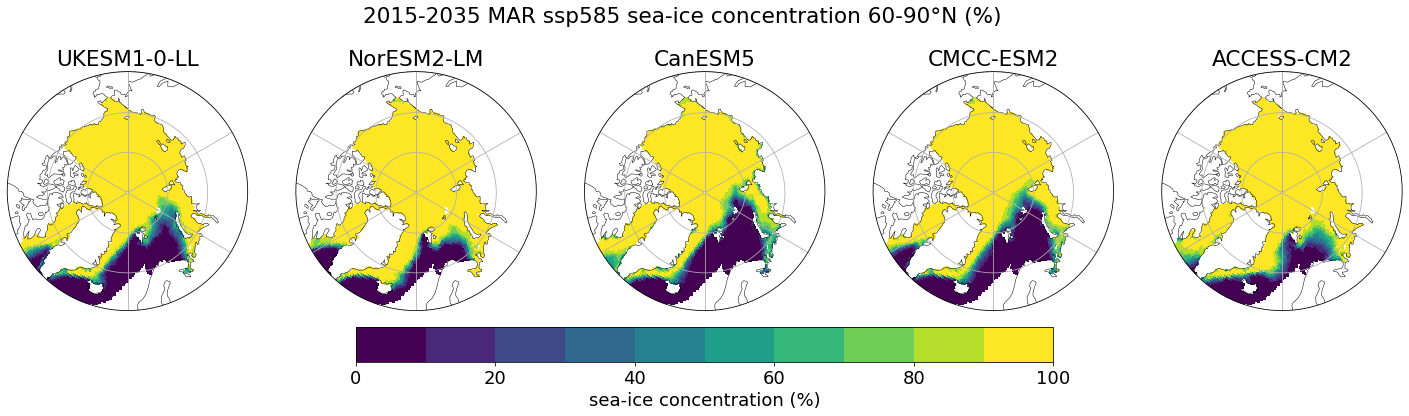

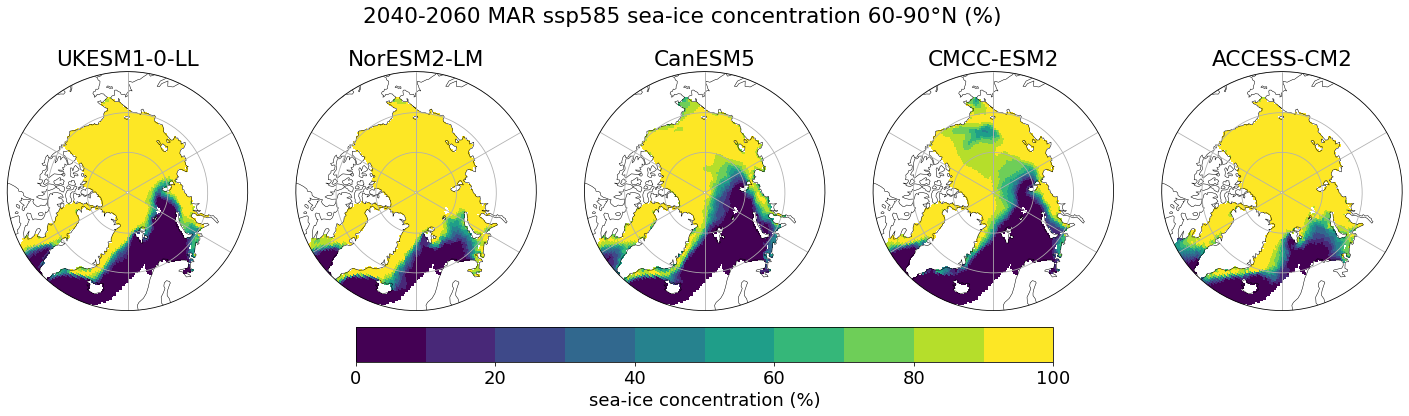

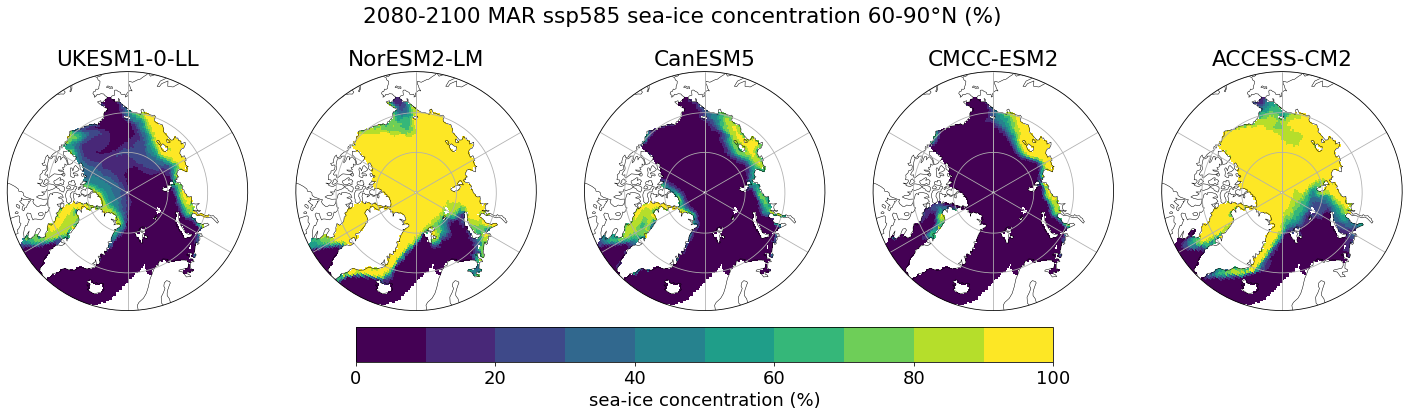

In [8]:
import warnings
warnings.filterwarnings('ignore')

libs.plot.calendar_division_spatial(
    ensemble_time_slices, 
    colormesh_kwargs=colormesh_kwargs,
    text=spatial_text,
    time='MAR',
    title='{label} {time} ssp585 {text} 60-90°N ({units})',
    units=spatial_units
)

### Full region September minimum (spatial)

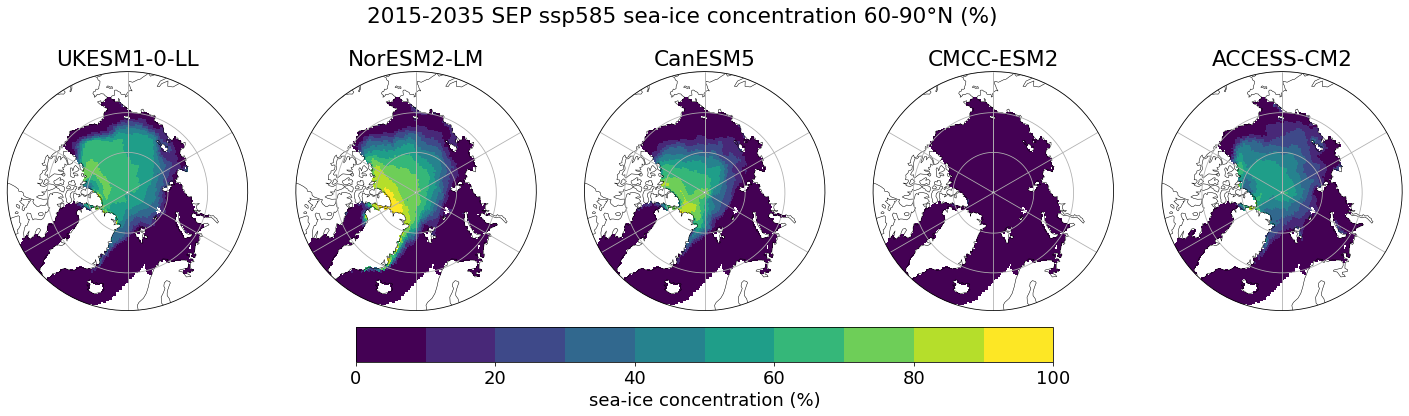

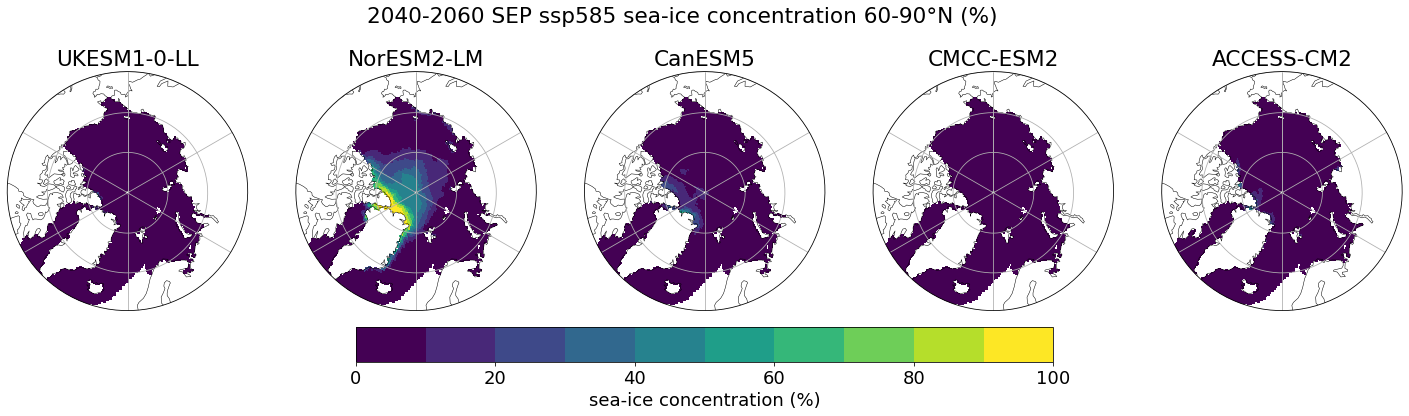

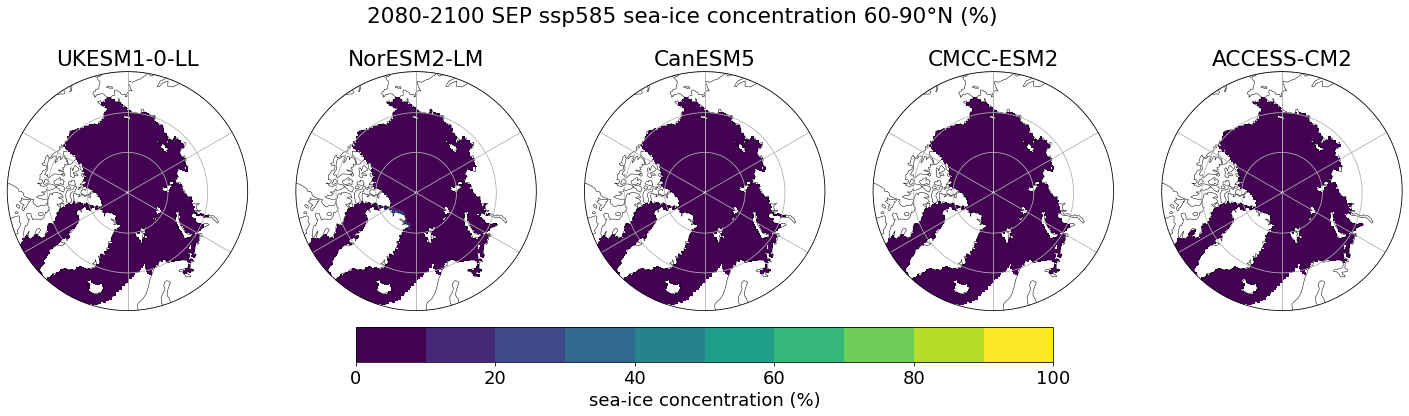

In [9]:
libs.plot.calendar_division_spatial(
    ensemble_time_slices, 
    colormesh_kwargs=colormesh_kwargs,
    text=spatial_text,
    time='SEP',
    title='{label} {time} ssp585 {text} 60-90°N ({units})',
    units=spatial_units
)